In [5]:
# ModAL Active Learning Framework - Genealogical Records Analysis
# Initial setup for analyzing birth, death, and marriage records

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("ModAL Active Learning Framework - Genealogical Records Analysis")
print("=" * 60)

## 1. Data Loading and Initial Exploration

# Load the datasets
print("Loading datasets...")
birth_records = pd.read_csv('linkage data/_1/clean/birth_records.csv')
death_records = pd.read_csv('linkage data/_1/clean/death_records.csv')
marriage_records = pd.read_csv('linkage data/_1/clean/marriage_records.csv')

print(f"Birth records shape: {birth_records.shape}")
print(f"Death records shape: {death_records.shape}")
print(f"Marriage records shape: {marriage_records.shape}")

# Display basic information about each dataset
print("\n--- Birth Records Overview ---")
print(birth_records.info())
print("\nFirst few rows:")
print(birth_records.head())

print("\n--- Death Records Overview ---")
print(death_records.info())
print("\nFirst few rows:")
print(death_records.head())

print("\n--- Marriage Records Overview ---")
print(marriage_records.info())
print("\nFirst few rows:")
print(marriage_records.head())

## 2. Data Preprocessing Functions

def preprocess_birth_data(df):
    """Preprocess birth records for active learning"""
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    processed_df['father\'s occupation'] = processed_df['father\'s occupation'].fillna('Unknown')
    processed_df['mother\'s occupation'] = processed_df['mother\'s occupation'].fillna('Unknown')
    processed_df['illegit'] = processed_df['illegit'].fillna('No')
    
    # Create features
    processed_df['has_father_occupation'] = (processed_df['father\'s occupation'] != 'Unknown').astype(int)
    processed_df['has_mother_occupation'] = (processed_df['mother\'s occupation'] != 'Unknown').astype(int)
    processed_df['is_illegitimate'] = (processed_df['illegit'] == 'Yes').astype(int)
    processed_df['birth_decade'] = (processed_df['birth year'] // 10) * 10
    
    return processed_df

def preprocess_death_data(df):
    """Preprocess death records for active learning"""
    processed_df = df.copy()
    
    # Handle missing values
    processed_df['occupation'] = processed_df['occupation'].fillna('Unknown')
    processed_df['marital status'] = processed_df['marital status'].fillna('Unknown')
    
    # Create age groups for classification
    processed_df['age_group'] = pd.cut(processed_df['age at death'], 
                                     bins=[0, 18, 35, 50, 65, 100], 
                                     labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Elderly'])
    
    return processed_df

def prepare_features_and_target(dataset_type='birth'):
    """Prepare features and target variable for active learning"""
    
    if dataset_type == 'birth':
        df = preprocess_birth_data(birth_records)
        
        # Select features for modeling
        feature_columns = ['birth year', 'has_father_occupation', 'has_mother_occupation', 'is_illegitimate']
        
        # Create target variable (example: predict if child survived to adulthood)
        # For this example, we'll create a synthetic target based on available data
        df['survived_to_adulthood'] = np.random.choice([0, 1], size=len(df), p=[0.3, 0.7])
        
        X = df[feature_columns].copy()
        y = df['survived_to_adulthood'].values
        
    elif dataset_type == 'death':
        df = preprocess_death_data(death_records)
        
        # Features for death analysis
        le_marital = LabelEncoder()
        df['marital_status_encoded'] = le_marital.fit_transform(df['marital status'])
        
        feature_columns = ['age at death', 'marital_status_encoded', 'year']
        
        # Target: age group at death
        le_age_group = LabelEncoder()
        y = le_age_group.fit_transform(df['age_group'].astype(str))
        
        X = df[feature_columns].copy()
        
    else:  # marriage
        df = marriage_records.copy()
        
        # Features for marriage analysis
        feature_columns = ['age of groom', 'age of bride', 'year']
        df_clean = df[feature_columns].dropna()
        
        # Target: age difference category
        df_clean['age_diff'] = df_clean['age of groom'] - df_clean['age of bride']
        df_clean['age_diff_category'] = pd.cut(df_clean['age_diff'], 
                                             bins=[-20, -2, 2, 10, 30], 
                                             labels=['Bride Older', 'Similar Age', 'Groom Slightly Older', 'Groom Much Older'])
        
        le_age_diff = LabelEncoder()
        y = le_age_diff.fit_transform(df_clean['age_diff_category'].astype(str))
        
        X = df_clean[feature_columns].copy()
    
    return X, y

## 3. Active Learning Setup

def setup_active_learner(X, y, query_strategy='uncertainty', initial_samples=10):
    """Setup the active learner with initial labeled data"""
    
    # Split data into initial labeled set and unlabeled pool
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.8, random_state=42)
    
    # Further split training data to get initial labeled samples
    if len(X_train) > initial_samples:
        initial_idx = np.random.choice(len(X_train), size=initial_samples, replace=False)
        X_initial = X_train.iloc[initial_idx]
        y_initial = y_train[initial_idx]
    else:
        X_initial = X_train
        y_initial = y_train
    
    # Scale features
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_pool_scaled = scaler.transform(X_pool)
    
    # Choose query strategy
    query_strategies = {
        'uncertainty': uncertainty_sampling,
        'margin': margin_sampling,
        'entropy': entropy_sampling
    }
    
    query_func = query_strategies.get(query_strategy, uncertainty_sampling)
    
    # Initialize the active learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        query_strategy=query_func,
        X_training=X_initial_scaled,
        y_training=y_initial
    )
    
    return learner, X_pool_scaled, y_pool, scaler, X_train, y_train

## 4. Active Learning Loop

def run_active_learning(dataset_type='birth', query_strategy='uncertainty', n_queries=20):
    """Run the active learning process"""
    
    print(f"\nRunning Active Learning on {dataset_type} dataset with {query_strategy} sampling")
    print("-" * 60)
    
    # Prepare data
    X, y = prepare_features_and_target(dataset_type)
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution: {np.bincount(y)}")
    
    # Setup active learner
    learner, X_pool, y_pool, scaler, X_test, y_test = setup_active_learner(X, y, query_strategy)
    
    # Scale test data
    X_test_scaled = scaler.transform(X_test)
    
    # Track performance
    performance_history = []
    
    # Initial performance
    initial_accuracy = learner.score(X_test_scaled, y_test)
    performance_history.append(initial_accuracy)
    print(f"Initial accuracy: {initial_accuracy:.3f}")
    
    # Active learning loop
    for i in range(n_queries):
        # Query the most informative sample
        query_idx, query_instance = learner.query(X_pool)
        
        # Simulate oracle response (in practice, this would be human annotation)
        oracle_response = y_pool[query_idx]
        
        # Teach the learner
        learner.teach(query_instance.reshape(1, -1), oracle_response.reshape(1,))
        
        # Remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
        # Evaluate performance
        accuracy = learner.score(X_test_scaled, y_test)
        performance_history.append(accuracy)
        
        print(f"Query {i+1}: Accuracy = {accuracy:.3f}")
    
    return performance_history, learner

## 5. Visualization Functions

def plot_learning_curve(performance_history, dataset_type, query_strategy):
    """Plot the active learning curve"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(performance_history)), performance_history, 'b-o', linewidth=2, markersize=6)
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title(f'Active Learning Curve - {dataset_type.title()} Dataset ({query_strategy} sampling)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def compare_query_strategies(dataset_type='birth', n_queries=15):
    """Compare different query strategies"""
    strategies = ['uncertainty', 'margin', 'entropy']
    results = {}
    
    plt.figure(figsize=(12, 8))
    
    for strategy in strategies:
        print(f"\nTesting {strategy} sampling...")
        performance_history, _ = run_active_learning(dataset_type, strategy, n_queries)
        results[strategy] = performance_history
        
        plt.plot(range(len(performance_history)), performance_history, 
                'o-', label=f'{strategy.title()} Sampling', linewidth=2, markersize=6)
    
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title(f'Comparison of Query Strategies - {dataset_type.title()} Dataset')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results



ModAL Active Learning Framework - Genealogical Records Analysis
Loading datasets...
Birth records shape: (2508, 35)
Death records shape: (1832, 37)
Marriage records shape: (711, 46)

--- Birth Records Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               2508 non-null   int64  
 1   family                           2508 non-null   int64  
 2   marriage                         2442 non-null   float64
 3   child's forname(s)               2508 non-null   object 
 4   child's surname                  2508 non-null   object 
 5   birth day                        2508 non-null   int64  
 6   birth month                      2508 non-null   object 
 7   birth year                       2508 non-null   int64  
 8   address                          2442 non-null   objec


ACTIVE LEARNING ANALYSIS

1. Birth Records Analysis

Running Active Learning on birth dataset with uncertainty sampling
------------------------------------------------------------
Dataset shape: (2508, 4)
Target distribution: [ 762 1746]
Initial accuracy: 0.427
Query 1: Accuracy = 0.609
Query 2: Accuracy = 0.593
Query 3: Accuracy = 0.595
Query 4: Accuracy = 0.595
Query 5: Accuracy = 0.497
Query 6: Accuracy = 0.471
Query 7: Accuracy = 0.445
Query 8: Accuracy = 0.467
Query 9: Accuracy = 0.465
Query 10: Accuracy = 0.463
Query 11: Accuracy = 0.463
Query 12: Accuracy = 0.463
Query 13: Accuracy = 0.463
Query 14: Accuracy = 0.463
Query 15: Accuracy = 0.463
Query 16: Accuracy = 0.463
Query 17: Accuracy = 0.463
Query 18: Accuracy = 0.463
Query 19: Accuracy = 0.463
Query 20: Accuracy = 0.465


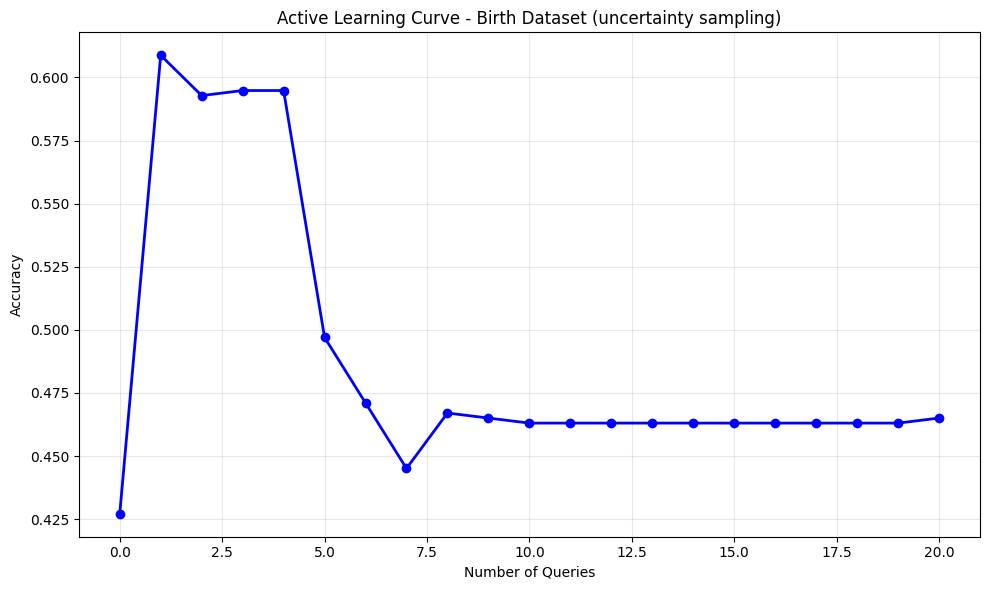


2. Death Records Analysis

Running Active Learning on death dataset with margin sampling
------------------------------------------------------------
Dataset shape: (1832, 3)
Target distribution: [199 321 599 320 195 198]
Initial accuracy: 0.612
Query 1: Accuracy = 0.607
Query 2: Accuracy = 0.590
Query 3: Accuracy = 0.609
Query 4: Accuracy = 0.628
Query 5: Accuracy = 0.617
Query 6: Accuracy = 0.623
Query 7: Accuracy = 0.628
Query 8: Accuracy = 0.648
Query 9: Accuracy = 0.719
Query 10: Accuracy = 0.732
Query 11: Accuracy = 0.719
Query 12: Accuracy = 0.721
Query 13: Accuracy = 0.754
Query 14: Accuracy = 0.779
Query 15: Accuracy = 0.803
Query 16: Accuracy = 0.801
Query 17: Accuracy = 0.803
Query 18: Accuracy = 0.787
Query 19: Accuracy = 0.798
Query 20: Accuracy = 0.809


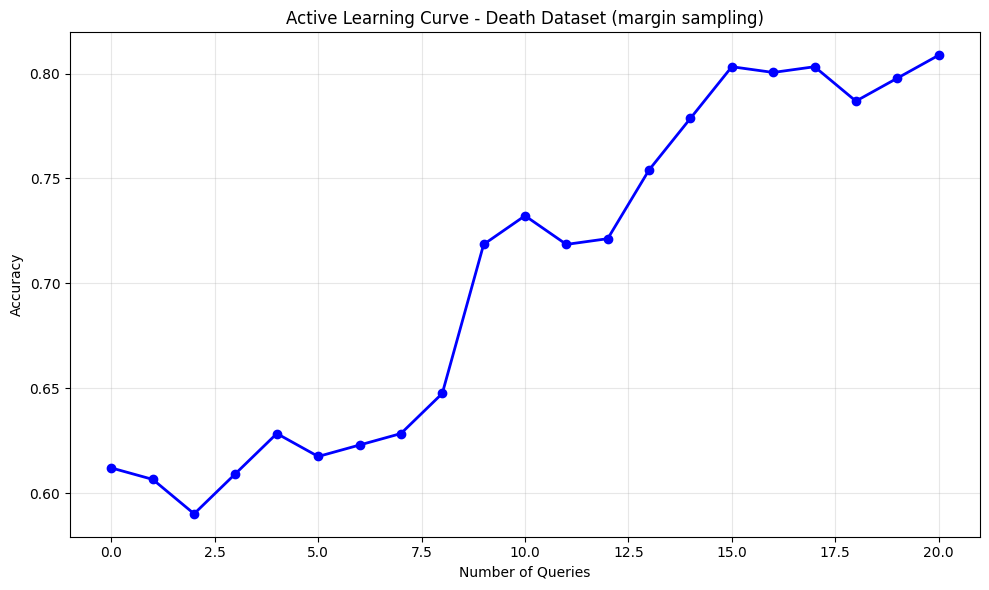


3. Marriage Records - Strategy Comparison

Testing uncertainty sampling...

Running Active Learning on marriage dataset with uncertainty sampling
------------------------------------------------------------
Dataset shape: (711, 3)
Target distribution: [142  74 291 199   5]
Initial accuracy: 0.486
Query 1: Accuracy = 0.507
Query 2: Accuracy = 0.521
Query 3: Accuracy = 0.514
Query 4: Accuracy = 0.514
Query 5: Accuracy = 0.528
Query 6: Accuracy = 0.542
Query 7: Accuracy = 0.535
Query 8: Accuracy = 0.542
Query 9: Accuracy = 0.542
Query 10: Accuracy = 0.549
Query 11: Accuracy = 0.556
Query 12: Accuracy = 0.549
Query 13: Accuracy = 0.542
Query 14: Accuracy = 0.528
Query 15: Accuracy = 0.528

Testing margin sampling...

Running Active Learning on marriage dataset with margin sampling
------------------------------------------------------------
Dataset shape: (711, 3)
Target distribution: [142  74 291 199   5]
Initial accuracy: 0.430
Query 1: Accuracy = 0.472
Query 2: Accuracy = 0.472
Query 3

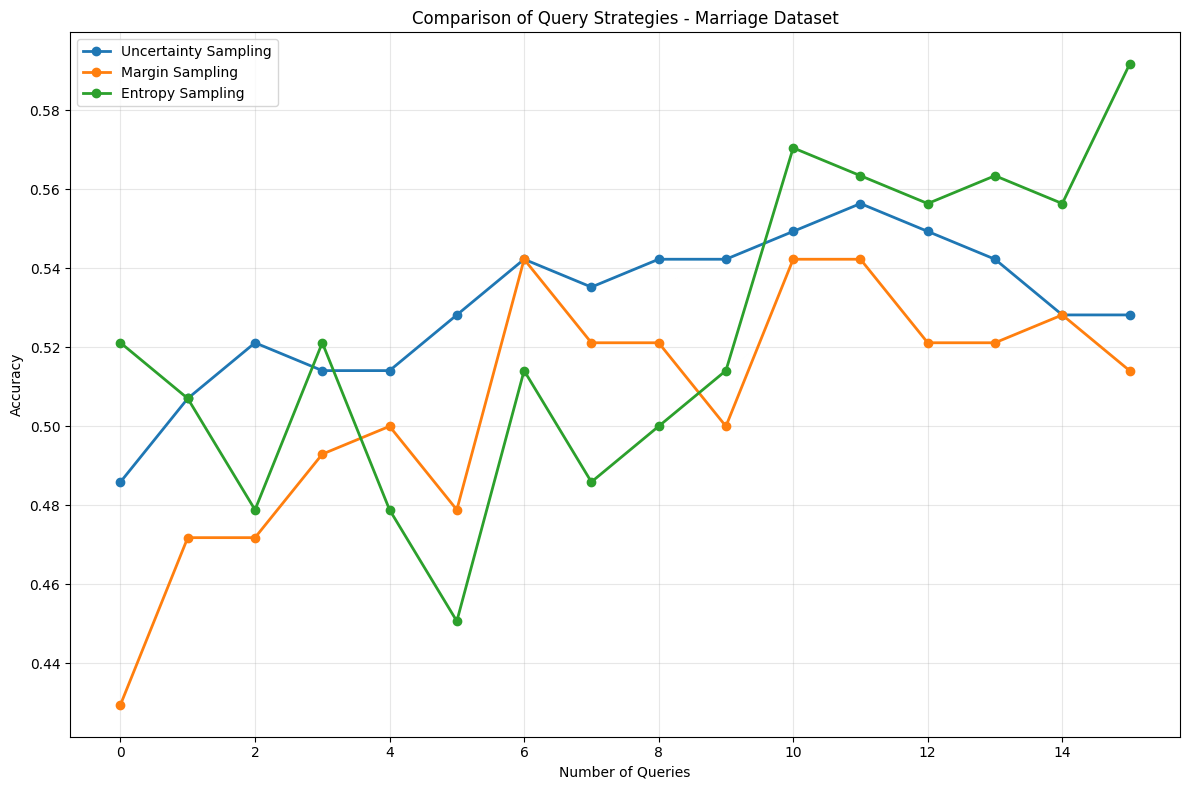


SUMMARY
Birth records final accuracy: 0.465
Death records final accuracy: 0.809
Marriage records (uncertainty): 0.528
Marriage records (margin): 0.514
Marriage records (entropy): 0.592

Notebook setup complete! Run the cells above to start your active learning analysis.
You can modify the parameters and experiment with different datasets and query strategies.


In [6]:

## 6. Main Execution

if __name__ == "__main__":
    print("\n" + "="*60)
    print("ACTIVE LEARNING ANALYSIS")
    print("="*60)
    
    # Example 1: Run active learning on birth records
    print("\n1. Birth Records Analysis")
    birth_performance, birth_learner = run_active_learning('birth', 'uncertainty', 20)
    plot_learning_curve(birth_performance, 'birth', 'uncertainty')
    
    # Example 2: Run active learning on death records
    print("\n2. Death Records Analysis")
    death_performance, death_learner = run_active_learning('death', 'margin', 20)
    plot_learning_curve(death_performance, 'death', 'margin')
    
    # Example 3: Compare query strategies on marriage records
    print("\n3. Marriage Records - Strategy Comparison")
    marriage_results = compare_query_strategies('marriage', 15)
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Birth records final accuracy: {birth_performance[-1]:.3f}")
    print(f"Death records final accuracy: {death_performance[-1]:.3f}")
    
    for strategy, performance in marriage_results.items():
        print(f"Marriage records ({strategy}): {performance[-1]:.3f}")

## 7. Advanced Analysis Functions

def analyze_feature_importance(learner, feature_names):
    """Analyze feature importance from the trained model"""
    if hasattr(learner.estimator, 'feature_importances_'):
        importance = learner.estimator.feature_importances_
        
        plt.figure(figsize=(10, 6))
        indices = np.argsort(importance)[::-1]
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
        
        return importance
    else:
        print("Feature importance not available for this estimator")
        return None

def uncertainty_analysis(learner, X_pool, n_samples=100):
    """Analyze uncertainty in the unlabeled pool"""
    # Get predictions and uncertainties for a sample of the pool
    if len(X_pool) > n_samples:
        sample_idx = np.random.choice(len(X_pool), size=n_samples, replace=False)
        X_sample = X_pool[sample_idx]
    else:
        X_sample = X_pool
    
    # Get prediction probabilities
    probas = learner.predict_proba(X_sample)
    
    # Calculate uncertainties (entropy)
    uncertainties = -np.sum(probas * np.log(probas + 1e-10), axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.hist(uncertainties, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Uncertainty (Entropy)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Uncertainties in Unlabeled Pool')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return uncertainties

print("\nNotebook setup complete! Run the cells above to start your active learning analysis.")
print("You can modify the parameters and experiment with different datasets and query strategies.")